In [1]:
import numpy as np
from mpmath import hyp2f1
from mpmath import ln as arbprec_ln
from scipy.special import gammaln
from scipy.special import gamma as gammafn
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
# first make mpmath's hypgeom vectorizable for convenience
np_2f1 = np.frompyfunc(
    lambda a, b, c, z: hyp2f1(a, b, c, z), 4, 1
)

#### Let's try one of the easy cases
(00+) has an easy minimal solution for $n\rightarrow\infty$: it's just $_2F_1(a,b,c+n;z)$ for $Re(z)<1/2$. The TTRR is
\begin{align}
(c+n)(c+n-1)(z-1)y_{n-1} + (c+n)[c+n-1-(2c+2n-a-b-1)z]y_n + (c+n-a)(c+n-b)zy_{n+1} = 0
\end{align}
So if we start with $n$ large and run backwards to $n$ small, the claim is that we should maintain numerical stability. Let's see. Rearrange TTRR to facilitate this:
\begin{align}
y_{n-1} = -\frac{1}{(c+n)(c+n-1)(z-1)} [(c+n)[c+n-1-(2(c+n)-a-b-1)z]y_n + (c+n-a)(c+n-b)zy_{n+1}]
\end{align}


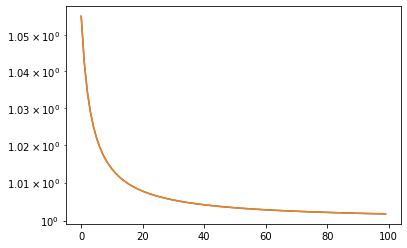

In [3]:
# rev recursion
n = np.arange(0,100)
a = 4.5
b = 0.2
c = 3.8
z = 0.2
mp_math2F1 = np.asfarray(np_2f1(a, b, c+n, z))
min2F1 = np.zeros_like(mp_math2F1)
min2F1[-2:] = mp_math2F1[-2:]
# python indexing rules make the indexing here horribly confusing,
# haven't yet figured out a better/more transparent way
for i, k in enumerate(np.arange(n[-1]-1, n[0], -1)):
    ck = c+k
    prefac_n = ck * (ck - 1 - (2 * ck - a - b - 1)*z)
    prefac_np1 = (ck - a) * (ck - b) * z
    denom = ck * (ck - 1) * (z - 1)
    min2F1[-(3+i)] = - (prefac_n * min2F1[-(2+i)] + prefac_np1 * min2F1[-(1+i)]) / denom
plt.semilogy(n, mp_math2F1)
plt.semilogy(n, min2F1);

Ok, so that's pretty magical. Play with different a,b,c and see many different behaviors, but the minimal solution tracks perfectly.

#### Harder case of actual interest
Now, how do we translate things when the minimal solution is not so simple? Let's try and run (+00) backwards. From 15.2.10 in Abramowitz & Stegun, the TTRR is
\begin{align}
(c-a)F(a-1,b,c;z) + (2a-c-az+bz)F(a,b,c;z) + a(z-1)F(a+1,b,c;z)=0.
\end{align}
To run backwards, rearrange to
\begin{align}
F(a-1,b,c;z) = - \frac{1}{(c-a)}[ (2a-c-az+bz)F(a,b,c;z) + a(z-1)F(a+1,b,c;z) ].
\end{align}
I think what Pearson et al failed to explain was the indexing, though in hindsight it's "obvious." When you relabel $a\rightarrow a+k$, you have to do that everywhere in the above equation, giving
\begin{align}
y_{k-1} = - \frac{1}{(c-a-k)}[ (2(a+k)-c-(a+k)z+bz)y_k + (a+k)(z-1)y_{k+1} ].
\end{align}
The solutions of the TTRR are not just plain ${_2F_1(a,b,c,z)}$, there is a set of $y_k$ that satisfy the TTRR with extra prefactors and different parameters. Because of all the symmetry transformations that ${_2F_1}$ satisfies, any single TTRR has many related solutions.

Gil et al claim that the minimal solution as $k\rightarrow\infty$ for this, on the real line for $0<z<2$, is (eq 4.3)
\begin{align}
y_{4,k} = \frac{\Gamma(1+a-c+k)}{\Gamma(1+a+b-c+k)} {_2F_1}(a+k,b,1+a+b-c+k;1-z).
\end{align}
The confusing thing that I finally get: the recursion relations are labeled by (+00) or (+0-) or whatever, but those aren't the increments you actually use them to generate. Each recursion relation has a set of six solutions, the $y_k$ in Gil et al notation. You literally just plug in the $y_k$ into their TTRR: the $a,b,c$ in the complicated expressions in the $y_k$ correspond to the $a,b,c$ in the TTRR. In the example here, the TTRR increments $a$ only, but the solution $y_{4,k}$ increments its 1st _and_ 3rd arguments, so it generates all $_2F_1$ of the form ${_2F_1}(a+k,b,1+a+b-c+k;1-z)$. So if you want to know ${_2F_1}(a^\prime+k,b^\prime,c^\prime+k;z^\prime)$ for some values of $a^\prime+k,b^\prime,c^\prime+k;z^\prime$, you're in luck, this is the TTRR and the solution that'll do that, and you can get it for a whole bunch of $k$ with ease, if you start at the max $k$ and recurse down to smaller $k$. Set $b=b^\prime, a=a^\prime, c=1+a+b-c^\prime$, and $z=1-z^\prime$ and you'll get what you want.

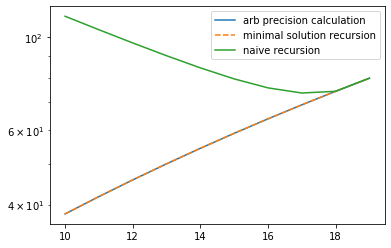

In [10]:
# rev recursion
k_burst = 5.2
mean_n = 3.6
kR_on = 4.5
kR_off = 3
rate_sum = k_burst + kR_off + kR_on
sqrt_discrim = np.sqrt((rate_sum)**2 - 4*k_burst*kR_off)
alpha = (rate_sum + sqrt_discrim) / 2.0
beta = (rate_sum - sqrt_discrim) / 2.0
gamma = kR_on + kR_off

n = np.arange(10,20)
a = alpha
b = gamma - beta
c = beta - alpha - 1
z = (1 + mean_n)**(-1)
gamma_numer = gammafn(1+a-c+n)
gamma_denom = gammafn(1+a+b-c+n)
mp_math2F1 = np.asfarray(np_2f1(a+n, b, 1+a+b-c+n, 1-z))
min2F1 = np.zeros_like(np.asfarray(n))
dum2F1 = np.zeros_like(min2F1)
dum2F1[-2:] = mp_math2F1[-2:]
min2F1[-1] = (np.exp(gammaln(1+a-c+n[-1]) - gammaln(1+a+b-c+n[-1]))
              * np_2f1(a+n[-1],b,1+a+b-c+n[-1],1-z))
min2F1[-2] = (np.exp(gammaln(1+a-c+n[-2]) - gammaln(1+a+b-c+n[-2]))
              * np_2f1(a+n[-2],b,1+a+b-c+n[-2],1-z))
# python indexing rules make the indexing here horribly confusing,
# haven't yet figured out a better/more transparent way
for i, k in enumerate(np.arange(n[-1]-1, n[0], -1)):
    apk = a+k
    prefac_k = 2*apk - c + (b - apk)*z
    prefac_kplus1 = apk*(z-1)
    denom = c - apk
    min2F1[-(3+i)] = - (prefac_k * min2F1[-(2+i)] + prefac_kplus1 * min2F1[-(1+i)]) / denom
    dum2F1[-(3+i)] = - (prefac_k * dum2F1[-(2+i)] + prefac_kplus1 * dum2F1[-(1+i)]) / denom
min2F1 *= (gamma_denom/gamma_numer)
plt.semilogy(n, mp_math2F1, label='arb precision calculation')
plt.plot(n, min2F1, '--', label='minimal solution recursion');
plt.plot(n, dum2F1, label='naive recursion')
plt.legend();

The naive recursion is so bad, I pretty sure I'm doing something dumb there. I added it as an afterthought and didn't think carefully about what I was calculating. It should gradually accumulate error, but it appears to diverge immediately. Not worth the time right now, maybe another time.

Recursion with the minimal solution seems robust (fractional error below $10^{-8}$, often down to $\sim10^{-13}$ for $a,b,c\lesssim5$) for $n$ up to 100 or so, even if $a,b,c$ are as large as 20 or 30 and even with funny signs. MUST have $0<z<2$ but that's fine. Use the expression for $P_m$ in the form
\begin{align}
P(m) = (prefac)\times {_2F_1}(\alpha+m, k_R^+ + k_R^- - \beta, k_R^+ + k_R^- + m;\frac{b}{1+b}).
\end{align}
With that we don't even have to restrict $b>1$ like I feared we might have had to with some of the other forms.

I think it's breaking for very large $n$ because of the gamma fcns, it could probably handle even higher values if I implemented Euler's reflection formula and wrapped `scipy.gammaln` rather than working with linear scale gamma. May be unnecessary to handle even larger $n\gtrsim100$ though. _Realized later that, since the rates that go into parameters are strictly positive, it follows from some algebra that the gamma fcn args are also strictly positive. So don't bother._